<a href="https://colab.research.google.com/github/loyedan/Data-Science-Tutorials/blob/main/Twitter_Whatsapp_Groups_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Whatsapp Groups Extractor**

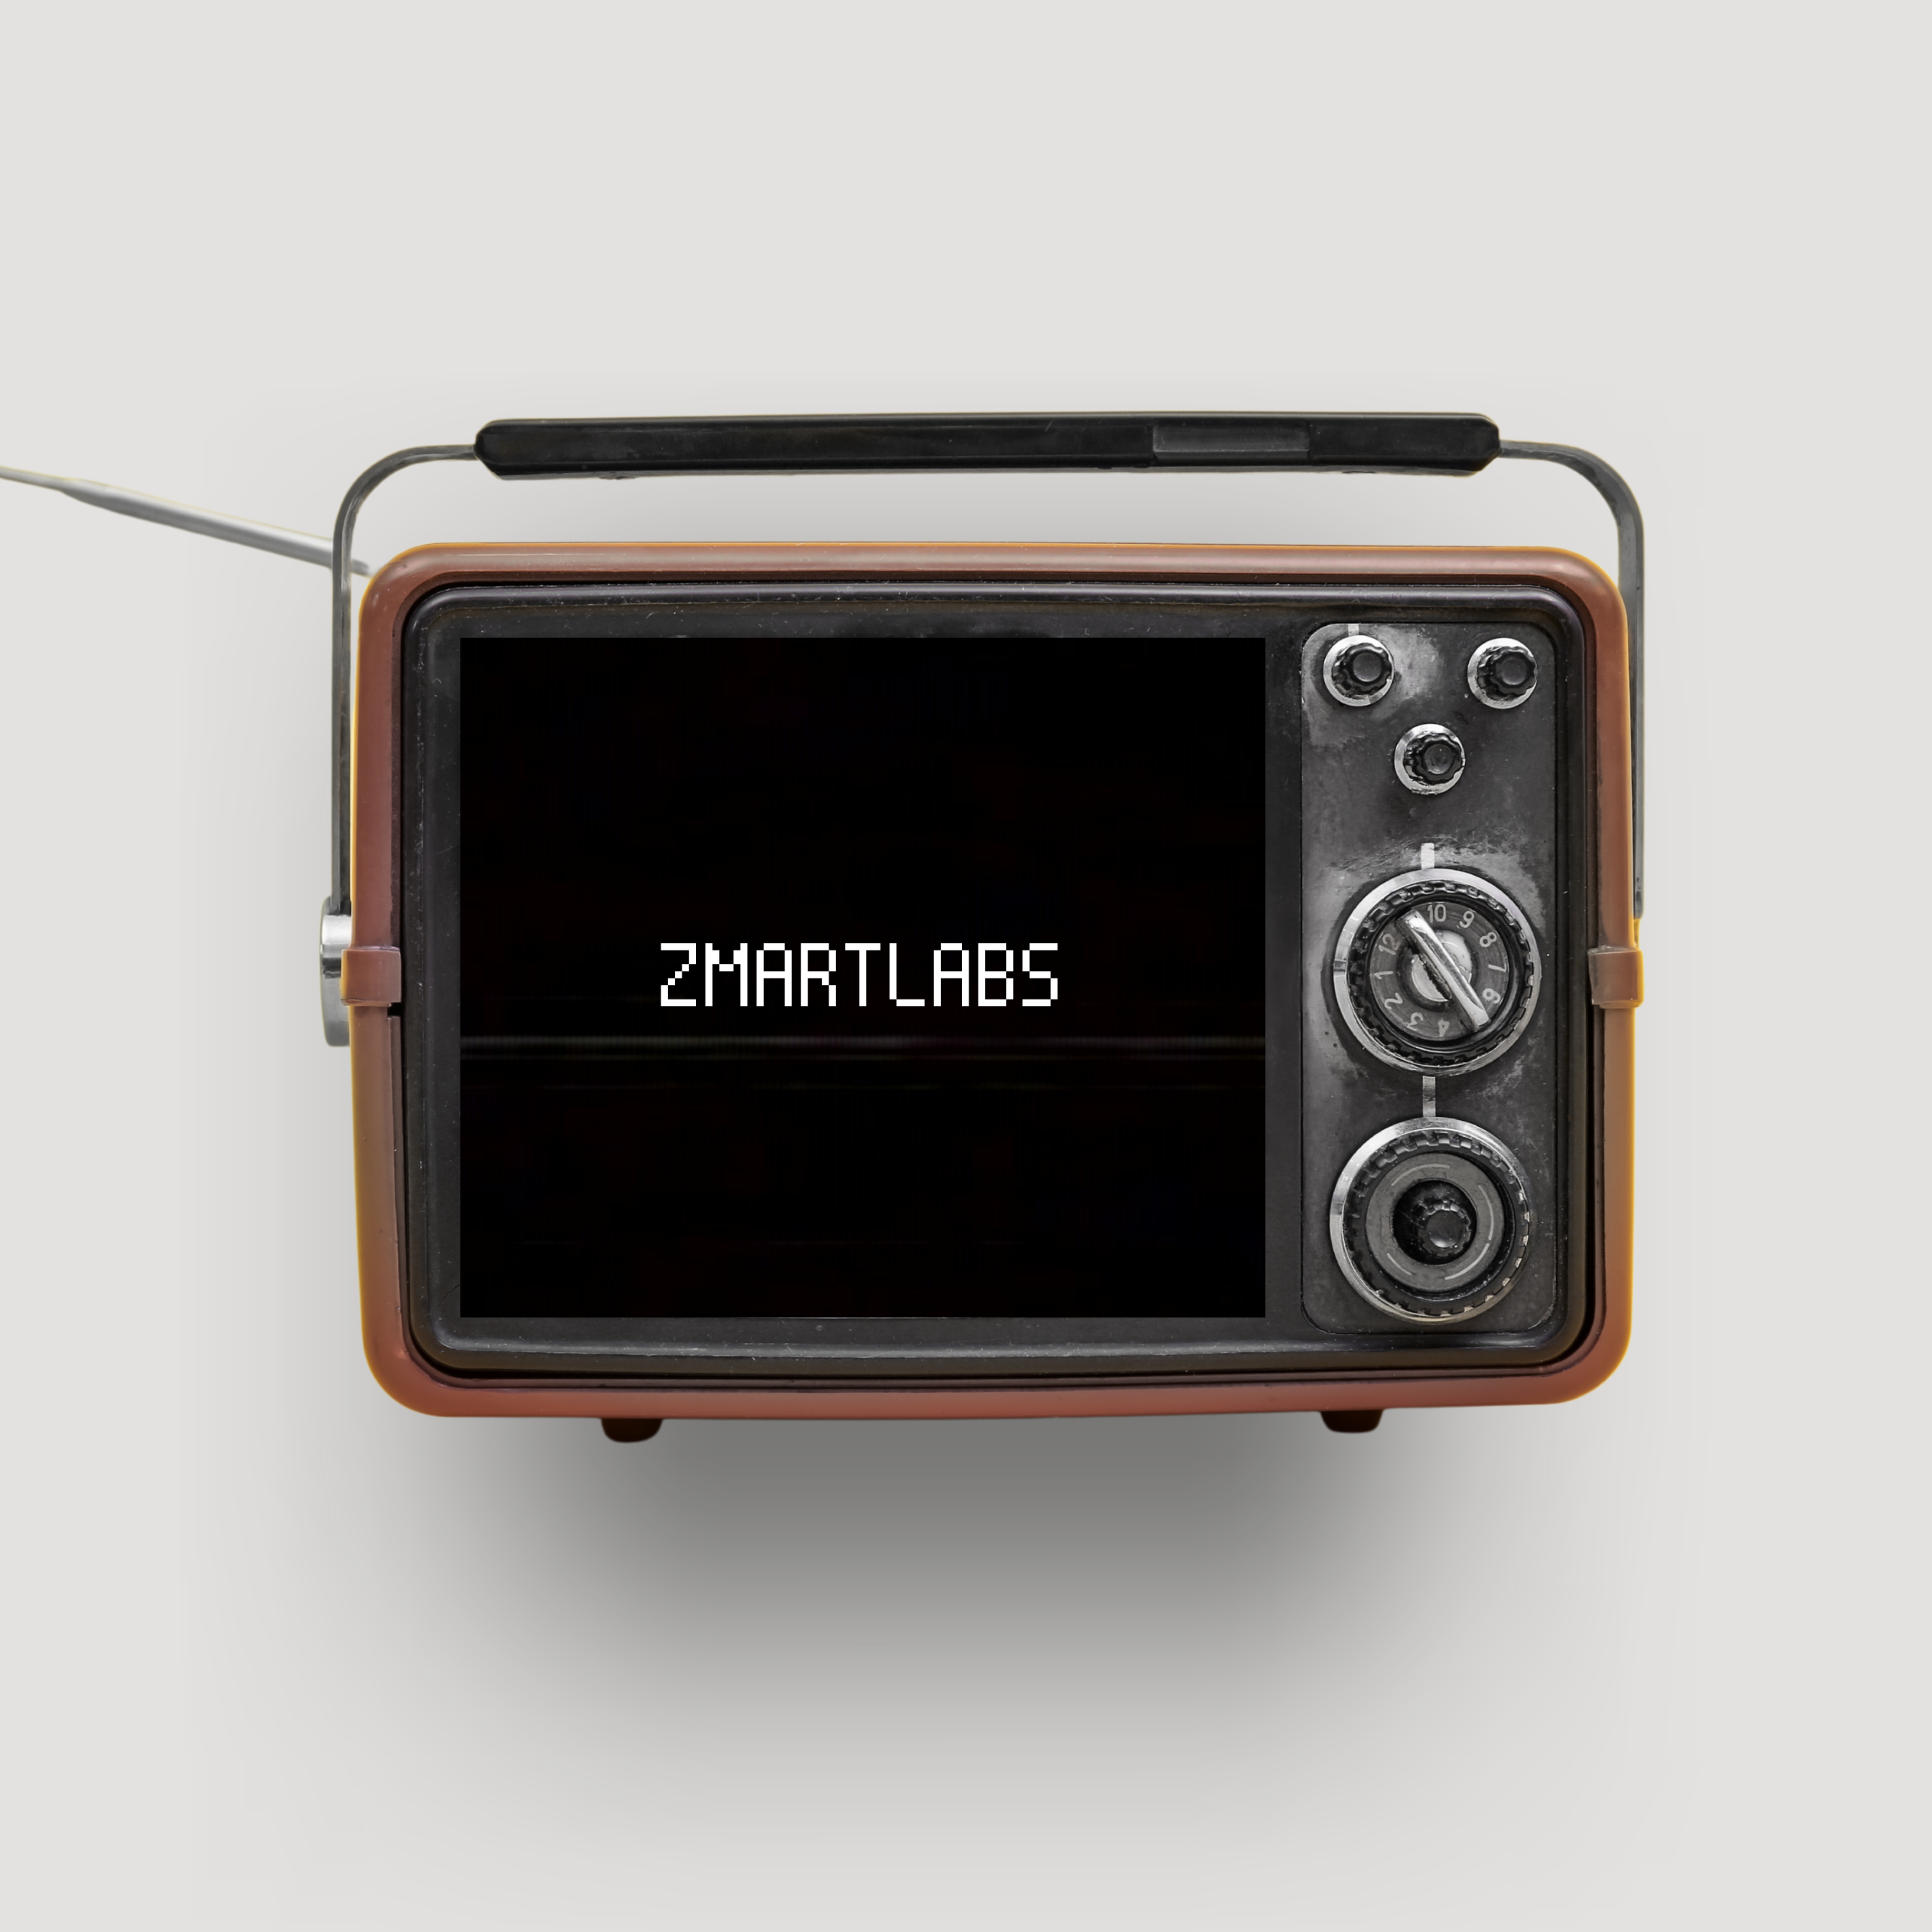

![preview](https://cdn.pixabay.com/photo/2013/06/07/09/53/twitter-117595_960_720.png)

This is a quick and dirty way to get a sense of what's trending on Twitter related to a particular Topic. For my use case, I am focusing on the city of Seattle but you can easily apply this to any topic.

**Use the GPU for this notebook to speed things up:** select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE".

The code in this notebook does the following things:


*   Scrapes Tweets related to the Topic you are interested in.
*   Extracts relevant Tags from the text (NER: Named Entity Recognition).
*   Does Sentiment Analysis on those Tweets.
*   Provides some visualizations in an interactive format to get a 'pulse' of what's happening.

We use Tweepy to scrape Twitter data and Flair to do NER / Sentiment Analysis. We use Seaborn for visualizations and all of this is possible because of the wonderful, free and fast (with GPU) Google Colab.

**A bit about NER (Named Entity Recognition)**

This is the process of extracting labels form text.

So, take an example sentence: 'George Washington went to Washington'. NER will allow us to extract labels such as Person for 'George Washington' and Location for 'Washington (state)'. It is one of the most common and useful applications in NLP and, using it, we can extract labels from Tweets and do analysis on them.

**A bit about Sentiment Analysis**

Most commonly, this is the process of getting a sense of whether some text is Positive or Negative. More generally, you can apply it to any label of your choosing (Spam/No Spam etc.).

So, 'I hated this movie' would be classified as a negative statement but 'I loved this movie' would be classified as positive. Again - it is a very useful application as it allows us to get a sense of people's opinions about something (Twitter topics, Movie reviews etc).

To learn more about these applications, check out the Flair Github homepage and Tutorials: https://github.com/zalandoresearch/flair


Note: You will need Twitter API keys (and of course a Twitter account) to make this work. You can get those by signing up here: https://developer.twitter.com/en/apps

To get up and running, we need to import a bunch of stuff and install Flair. Run through the next 3 cells.

In [ ]:
# import lots of stuff
import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# install Flair
!pip install --upgrade git+https://github.com/flairNLP/flair.git

clear_output()

In [ ]:
# import Flair stuff
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

clear_output()

In [ ]:
#import Flair Classifier
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

clear_output()

### Authenticate with Twitter API

In [ ]:
#@title Enter Twitter Credentials
TWITTER_KEY = '' #@param {type:"string"}
TWITTER_SECRET_KEY = '' #@param {type:"string"}

In [ ]:
# Authenticate
auth = tweepy.AppAuthHandler(TWITTER_KEY, TWITTER_SECRET_KEY)

api = tweepy.API(auth, wait_on_rate_limit=True,
				   wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)


###Lets start scraping!

The Twitter scrape code here was taken from: https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively.

My thanks to the author.

We need to provide a Search term and a Max Tweet count. Twitter lets you to request 45,000 tweets every 15 minutes  so setting something below that works.

In [ ]:
#@title Twitter Search API Inputs
#@markdown ### Enter Search Query:
searchQuery = 'chat.whatsapp.com university Ghana' #@param {type:"string"}
#@markdown ### Enter Max Tweets To Scrape:
#@markdown #### The Twitter API Rate Limit (currently) is 45,000 tweets every 15 minutes.
maxTweets = 1000 #@param {type:"slider", min:0, max:45000, step:100}
Filter_Retweets = True #@param {type:"boolean"}

tweetsPerQry = 100  # this is the max the API permits
tweet_lst = []

if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets'  # to exclude retweets

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -10000000000

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang="en")
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", since_id=sinceId)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1))
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1),
                                        since_id=sinceId)
        if not new_tweets:
            print("No more tweets found")
            break
        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"

          # fixup search query to get topic
          topic = searchQuery[:searchQuery.find('-')].capitalize().strip()

          # fixup date
          tweetDate = tweet.created_at.date()

          tweet_lst.append([tweetDate, topic,
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count,
                      reply_count, tweet.retweet_count, retweeted])

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

clear_output()
print("Downloaded {0} tweets".format(tweetCount))

##Data Sciencing

Let's load the tweet data into a Pandas Dataframe so we can do Data Science to it.

The data is also saved down in a tweets.csv file in case you want to download it.

In [ ]:
pd.set_option('display.max_colwidth', -1)

# load it into a pandas dataframe
tweet_df = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])
tweet_df.to_csv('tweets.csv')
tweet_df.head()

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2019-06-21,Seattle,1141989410399051776,LarryJuneTFM,GOOD JOB LARRY 🍊,@grailfinders 🍊🍾 quick studio session in Seattle https://t.co/LiZ1PxMutG https://t.co/RH6TtLH9qZ,1,0,1,False
1,2019-06-21,Seattle,1141989396008308736,mtgdungeon00,wardon wiltsey,Not terrible for for getting donation goal 5 days before magic fest Seattle and having to put this together. Hope t… https://t.co/X3GgwVRbwE,0,0,0,False
2,2019-06-21,Seattle,1141989264760041473,seaveyjoycelyn,Joy•Why Dont We,@BeautyChickee I live near Seattle can we still be friends? I’m in need of a best friend,0,0,0,False
3,2019-06-21,Seattle,1141989048879210497,brando_tron,Brando,@fakemikemulloy Seattle one day my dude.,0,0,0,False
4,2019-06-21,Seattle,1141989011772366848,HubShare,Hubshare,That’s a wrap! Thank you to everyone who attended the Hubshare and SAI Systems Auditing Lunch &amp; Learn series! We he… https://t.co/v5pdkCl8ce,0,0,0,False


Unfortunately Twitter does not let you filter by date when you request tweets. However, we can do this at this stage. I have set it up to pull yesterday + todays Tweets by default.

In [ ]:
#@title Filter By Date Range
today = datetime.now().date()
yesterday = today - timedelta(1)

start_dt = '2024-01-01' #@param {type:"date"}
end_dt = '2024-09-06' #@param {type:"date"}

if start_dt == '':
  start_dt = yesterday
else:
  start_dt = datetime.strptime(start_dt, '%Y-%m-%d').date()

if end_dt == '':
  end_dt = today
else:
  end_dt = datetime.strptime(end_dt, '%Y-%m-%d').date()


tweet_df = tweet_df[(tweet_df['tweet_dt'] >= start_dt)
                    & (tweet_df['tweet_dt'] <= end_dt)]
tweet_df.shape

(1026, 10)